# Pipeline : 
### data processing of the manually annoted dataset
### image processing : extraction of RGB volumes
### classifier based on WND-charm Model
### PCA & RDF
### Build a classifier
### Analyse False Positives
### Prediction of Neurons, Astrocytes, Background in ROI's clone

In [41]:
import numpy as np
import pandas as pd
from functools import partial
import multiprocessing
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as cm
import pickle
from pandas import DataFrame, read_csv,concat,merge

In [2]:
%run ./configure.ipynb

In [3]:
%run ../Connection_to_server.ipynb

In [4]:
imageId = 451
weight=25
height=25

## Pre-pocessing of the manually annotated Dataset

In [5]:
import Pre_Processing_the_annotated_dataset as pp
reload(pp);

In [6]:
dfpoints=read_csv(projectpath+'io/Input/Bloc01_pointes_first_mod.csv')

In [7]:
dfpoints=pp.Get_Dataframe(imageId, dfpoints)

## Reduce the number of Neurons in order to have as many as Astrocytes

In [8]:
import Reduction_of_Neurons_in_the_DataFrame as nr
reload(nr);

In [9]:
dfpoints=nr.Get_DataFrame_less_Neurons(dfpoints)

In [10]:
DF_=nr.Get_Data_frame(imageId, dfpoints)

In [11]:
import Fonctions_used_for_many_DF_pre_processing as fct_pp
reload(fct_pp);

In [12]:
Data_FRAMES=fct_pp.getDF(DF_)

In [13]:
Data_FRAMES=fct_pp.Switch_Indices(Data_FRAMES)

In [14]:
Data_FRAMES=fct_pp.exclure(Data_FRAMES,weight, height)

In [15]:
D_F=fct_pp.getDF(Data_FRAMES)

In [16]:
Data_FRAMES=fct_pp.Switch_Indices(D_F)

In [17]:
Data_FRAMES.to_pickle(projectpath+'io/Output/Data_FRAMES.pkl')

# Add a fourth class to the data Frame (Background Type :4)

In [18]:
Data_FRAMES=pd.read_pickle(projectpath+'io/Output/Data_FRAMES.pkl')

In [19]:
import Add_Background_class_to_Dataframe as Bc
reload(Bc);

In [20]:
New_DF=Bc.Get_Df_with_backgroung_class(Data_FRAMES,imageId)

In [21]:
New_DF=fct_pp.exclure_Bc(New_DF,weight,height)

In [22]:
New_DF=fct_pp.getDF(New_DF)

In [23]:
New_DF=fct_pp.Switch_Indices(New_DF)

540

# Create the full data Frame ( 526 Adtrocytes, 528 Neurons, 540 background) 

In [31]:
# Join the 2 DataFrames
Dataframe_=pd.concat([Data_FRAMES, New_DF], axis=0)

In [32]:
Dataframe_=fct_pp.getDF(Dataframe_)

In [33]:
Dataframe_=fct_pp.Switch_Indices(Dataframe_)

In [34]:
Dataframe_.to_pickle(projectpath+'io/Output/Dataframe_.pkl')

In [35]:
Data_FRAMES=pd.read_pickle(projectpath+'io/Output/Dataframe_.pkl')

# Get volumes with Multiprocessing

In [37]:
import Get_Partial_Data as gpd
reload(gpd);

In [38]:
zsize=3
nidx=Data_FRAMES.shape[0]

In [46]:
filename_M_DF =projectpath+'io/Output/M_DF.npy'

## Load Normalized volums as numpy array

In [47]:
M_DF_parallel=np.load(filename_M_DF)

# Display the RGB images corresponding to normalized volums

In [53]:
import Display_RGB_Vol as rgb_im
reload(rgb_im);

<IPython.core.display.Javascript object>


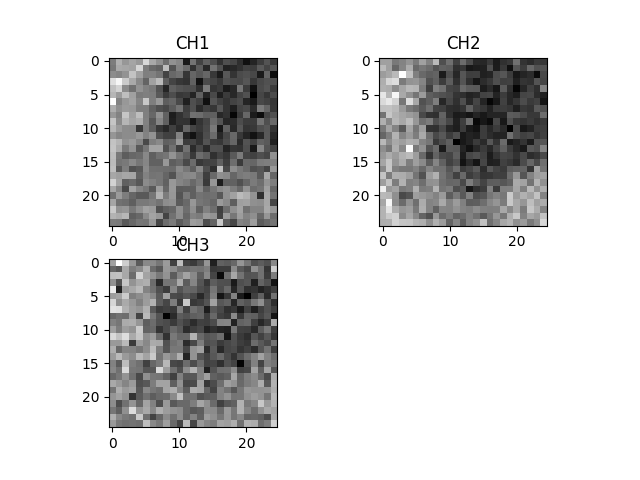

<IPython.core.display.Javascript object>


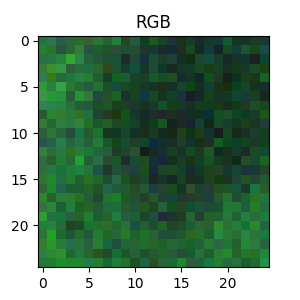

In [54]:
rgb_im.PLOT_Im(M_DF_parallel[100])

# 4- WND CHARM Method

## 4.1- Convert RGB images to Grayscale

In [ ]:
%%time
%run ./RGB2GRAY.ipynb

## Load the gray images as numpy array

In [ ]:
filename_Gray_IM =projectpath+'io/Output/GRAY_IM.npy'

In [ ]:
GRAY_IM_parallel=np.load(filename_Gray_IM)

# Display images by class ( 1 or 2)

## 4.2- Extraction of the WND-CHARM Features

In [ ]:
%%time
%run ./Features_Exctraction.ipynb

## Load the extracted Features

In [ ]:
filename_FEATURES =projectpath+'io/Output/FEATURES.npy'

In [ ]:
FEATURES=np.load(filename_FEATURES)

## Etablish one np.array for the Features' Names & another one for Features' Values

In [ ]:
FEAT_NAMES=FEATURES[:,1,:]

In [ ]:
FEAT_VALUES=FEATURES[:,0,:]

In [ ]:
FEAT_VALUES=FEAT_VALUES.astype(float)

In [ ]:
filename_FEATURES_Val =projectpath+'io/Output/FEATURES_Val.npy'

In [ ]:
np.save(filename_FEATURES_Val,FEAT_VALUES)

In [ ]:
FEAT_VALUES=np.load(filename_FEATURES_Val)

# 4.3- Features Post- processing

## A- Get the normalized Features

In [ ]:
%%time
%run ./Features_Normalization.ipynb

## Load the Normalized Features values

In [ ]:
filename_FVN =projectpath+'io/Output/FV_N.npy'

In [ ]:
FV_N=np.load(filename_FVN)

In [ ]:
FV_N.shape

# PCA & Random Forest Classification

In [ ]:
%%time
%run ./Pipeline_PCA_RANDOM_Forest_Copy1.ipynb
# CPU times: user 16min 53s, sys: 1h 52s, total: 1h 17min 45s
# Wall time: 6min 58s

# Imshow specific images to understand non differentiation in PCA model

# process in order to display false predicted images

# test prediction sur  1 clone

In [ ]:
import numpy as np
import pandas as pd
from functools import partial
import multiprocessing
from multiprocessing import Pool
from functools import partial

# FAIRE DES MODIFS !

In [ ]:
def get_coordinates(index_ligne,imageId, large):
    conn = BlitzGateway('tbacoyannis','d33pl34rn1ng',port=4064,host='chinensis.polytechnique.fr')
    connected = conn.connect()

    image = conn.getObject("Image", imageId)
    pixels = image.getPrimaryPixels() # get raw pixels information
    
    size_x= image.getSizeX()
    size_y= image.getSizeY()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
   
   
    delta_x=int(large/int(large/2))
    
    nb_fenetres=np.arange(size_x/delta_x)
    index=nb_fenetres
    
    x=(index*delta_x)+delta_x
    x=x[22:-22]
    print len(x)
    #x=x[2:-2]
    y=((index_ligne*delta_x)+delta_x)*np.ones(len(x)) #(index))
    
    
    index_colonne=index+2
    index_lignee=(2+index_ligne)*np.ones(len(x)) # FAUDRA CHANGER PAR index_lignee=(2+index_ligne)*np.ones(len(x))
    
    Tuple_Coord=(x,y,index_lignee, index_colonne) # RENOMMER CAR C EST TUPLE ET PAS UNE MATRICE
    
    Matrix=np.zeros((len(x),large,large,3))
    
    z=103
    
    tilewidths = np.ones(len(x),dtype=int)*large
    tileheights = tilewidths
    tilestacks = zip(x,y,tilewidths,tileheights)
    
    zstacks= np.ones(len(x),dtype=int)*z
    
    tstacks=np.zeros(len(x), dtype=int)
    
    for c in range(0,3):
        cstacks=np.ones(len(x), dtype=int)*c
        liste=zip(zstacks,cstacks,tstacks, tilestacks)
        pxobj = pixels.getTiles(liste)
        for i, p in enumerate(pxobj):
            Matrix[i,:,:,c]=p
    
    conn._closeSession()
    return(Matrix,Tuple_Coord)

## STOP

In [ ]:
conn = BlitzGateway('tbacoyannis','d33pl34rn1ng',port=4064,host='chinensis.polytechnique.fr')
connected = conn.connect()

image = conn.getObject("Image", imageId)
pixels = image.getPrimaryPixels() # get raw pixels information

size_x=image.getSizeX()
size_y=image.getSizeY()
size_z = image.getSizeZ()
size_c = image.getSizeC()
size_t = image.getSizeT()

imageId=451
zsize=3
large= 25  #50
#nidX=size_x/int(large/2)
nidY=size_x/(int(large/int(large/2)))-3

In [ ]:
nidY

In [ ]:
filename_res =projectpath+'io/Output/res.npy'

In [ ]:
res=np.load(filename_res)

In [ ]:
nn=res

In [ ]:
nn.shape

In [ ]:
M_Mv=nn[:,0]
liste_coordonnees=nn[:,1]

In [ ]:
x_min=48+367
y_min=2064+646
w=615-367
h=920-646
x_max=x_min+w
y_max=y_min+h

In [ ]:
b=np.vstack(liste_coordonnees)

In [ ]:
x_from_liste_coordonnees=b[:,0]
y_from_liste_coordonnees=b[:,1]
ind_lign_from_liste_coordonnees=b[:,2]
ind_col_from_liste_coordonnees=b[:,3]

In [ ]:
imag=M_Mv[:]

In [ ]:
filename_Matrix_TEST =projectpath+'io/Output/Matrix_TEST.npy'

In [ ]:
Matrix_TEST=np.load(filename_Matrix_TEST)

In [ ]:
Matrix_TEST.shape

In [ ]:
coords=np.where((np.hstack(x_from_liste_coordonnees)>=x_min) & (np.hstack(x_from_liste_coordonnees)<=x_max) & (np.hstack(y_from_liste_coordonnees)>=y_min) & (np.hstack(y_from_liste_coordonnees)<=y_max))[0]

In [ ]:
filename_Im_to_convert_GRAY =projectpath+'io/Output/Im_to_convert_GRAY.npy'

In [ ]:
Im_to_convert_GRAY=Matrix_TEST[coords]

In [ ]:
np.save(filename_Im_to_convert_GRAY ,Im_to_convert_GRAY)

In [ ]:
Im_to_convert_GRAY.shape

In [ ]:
%%time
%run ./RGB2GRAY_PREDICT.ipynb
# CPU times: user 1min 11s, sys: 2min 56s, total: 4min 7s
# Wall time: 10min 30s

In [ ]:
filename_GRAY_IM_TEST8PRED =projectpath+'io/Output/GRAY_IM_TEST8PRED.npy'

In [ ]:
GRAY_IM_TEST8PRED_parallel=np.load(filename_GRAY_IM_TEST8PRED)

In [ ]:
GRAY_IM_TEST8PRED_parallel.shape

In [ ]:
x_min=48+367
y_min=2064+646
w=615-367
h=920-646
x_max=x_min+w
y_max=y_min+h

In [ ]:
b=np.vstack(liste_coordonnees)

In [ ]:
x_from_liste_coordonnees=b[:,0]
y_from_liste_coordonnees=b[:,1]
ind_lign_from_liste_coordonnees=b[:,2]
ind_col_from_liste_coordonnees=b[:,3]

In [ ]:
coords=np.where((np.hstack(x_from_liste_coordonnees)>=x_min) & (np.hstack(x_from_liste_coordonnees)<=x_max) & (np.hstack(y_from_liste_coordonnees)>=y_min) & (np.hstack(y_from_liste_coordonnees)<=y_max))[0]

In [ ]:
filename_GRAY_IM_TEST_PRED =projectpath+'io/Output/GRAY_IM_TEST_PRED.npy'

In [ ]:
GRAY_IM_TEST_PRED_parallel=GRAY_IM_TEST8PRED_parallel[coords]

In [ ]:
np.save(filename_GRAY_IM_TEST_PRED,GRAY_IM_TEST_PRED_parallel)

In [ ]:
GRAY_IM_TEST8PRED_parallel=np.load(filename_GRAY_IM_TEST_PRED)

In [ ]:
GRAY_IM_TEST8PRED_parallel.shape

In [ ]:
%%time
%run ./Features_Exctraction_PREDICT.ipynb
# CPU times: user 19.7 s, sys: 13.6 s, total: 33.3 s
# Wall time: 18min 9s

In [ ]:
filename_FEATURES_TEST =projectpath+'io/Output/FEATURES_TEST.npy'

In [ ]:
FEATURES_TEST=np.load(filename_FEATURES_TEST)

In [ ]:
FEATURES_TEST.shape

In [ ]:
FEATURES_TEST_NAMES=FEATURES_TEST[:,1,:]

In [ ]:
FEATURES_TEST_VALUES=FEATURES_TEST[:,0,:]

In [ ]:
FEATURES_TEST_VALUES=FEATURES_TEST_VALUES.astype(float)

In [ ]:
filename_FEATURES_TEST_VALUES =projectpath+'io/Output/FEATURES_TEST_VALUES.npy'

In [ ]:
np.save(filename_FEATURES_TEST_VALUES,FEATURES_TEST_VALUES)

In [ ]:
FEATURES_TEST_VALUES=np.load(filename_FEATURES_TEST_VALUES)

In [ ]:
%%time
%run ./Features_Normalization_PREDICT.ipynb
#CPU times: user 10.2 s, sys: 24.4 s, total: 34.6 s
#Wall time: 44.9 s

In [ ]:
filename_FVN_TEST =projectpath+'io/Output/FV_N_TEST.npy'

In [ ]:
FV_N_TEST=np.load(filename_FVN_TEST)

In [ ]:
FV_N_TEST.shape

In [ ]:
%%time
%run ./Pipeline_PCA_RANDOM_Forest_Copy1_PREDICT.ipynb

In [ ]:
filename_prediction_TEST =projectpath+'io/Output/prediction_TEST.npy'
prediction_TEST=np.load(filename_prediction_TEST)

In [ ]:
filename_predict_probability=projectpath+'io/Output/predict_probability.npy'
predict_probability=np.load(filename_predict_probability)

In [ ]:
predict_probability[0]

## Process for one tile ipynb

In [ ]:
filename_Im_Proba =projectpath+'io/Output/Im_Proba.npy'
Im_Proba=np.load(filename_Im_Proba)

In [ ]:
Im_proba=np.zeros([Im_Proba.shape[0], Im_Proba.shape[2]])

for g in range(0,Im_Proba.shape[0]):
    Im_proba[g]=Im_Proba[g][g]

In [ ]:
filename_Im_proba =projectpath+'io/Output/Im_proba.npy'

In [ ]:
Im_Proba=np.save(filename_Im_proba,Im_proba)

In [ ]:
Im_Proba=np.load(filename_Im_proba)

In [ ]:
plt.figure()
plt.title('predict_probability Neurons VS predict_probability Background')
plt.scatter(Im_Proba[:,1],Im_Proba[:,0])

In [ ]:
plt.figure()
plt.title('histogram of Astrocytes proba')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.hist(Im_Proba[:,0],bins=50)

In [ ]:
# predict_probabiConversion_test_predict_probability=np.reshape(Conversion_test_predict_probability, (-1,3,72))
#%matplotlib notebook

In [ ]:
Probability_img=np.zeros([Im_Proba.shape[0]+1,Im_Proba.shape[1]])
Probability_img[:Im_Proba.shape[0]]=Im_Proba
Probability_img[Im_Proba.shape[0]]=Probability_img[Im_Proba.shape[0]-1]

In [ ]:
CH1=Probability_img[:,0]
# CH1=np.reshape(CH1, (-1, 76) )
e=len(coords[:1+(x_max-x_min)/int(large/2)])
e=124
CH1=np.reshape(CH1, (-1, e) )

CH1=CH1[:,:, np.newaxis]
#     plt.title('Proba Astrocytes')

CH2=Probability_img[:,1]
#CH2=np.reshape(CH2,(-1,76))

CH2=np.reshape(CH2,(-1,e))

CH2=CH2[:,:,np.newaxis]
#     plt.title('Proba Neurons')


CH3=Probability_img[:,2]
#CH3=np.reshape(CH3, (-1, 76) )

CH3=np.reshape(CH3, (-1, e) )

CH3=CH3[:,:,np.newaxis]
#     plt.title('Proba Background')

Z=np.dstack([CH1,CH2,CH3])

In [ ]:
CH1=predict_probability[:,0]
# CH1=np.reshape(CH1, (-1, 76) )
e=len(coords[:1+(x_max-x_min)/int(large/2)])

CH1=np.reshape(CH1, (-1, e) )

CH1=CH1[:,:, np.newaxis]
#     plt.title('Proba Astrocytes')

CH2=predict_probability[:,1]
#CH2=np.reshape(CH2,(-1,76))

CH2=np.reshape(CH2,(-1,e))

CH2=CH2[:,:,np.newaxis]
#     plt.title('Proba Neurons')


CH3=predict_probability[:,2]
#CH3=np.reshape(CH3, (-1, 76) )

CH3=np.reshape(CH3, (-1, e) )

CH3=CH3[:,:,np.newaxis]
#     plt.title('Proba Background')

Z=np.dstack([CH1,CH2,CH3])

In [ ]:
filename_RGB_proba_im =projectpath+'io/Output/RGB_proba_im.npy'

In [ ]:
np.save(filename_RGB_proba_im,Z)

In [ ]:
Z=np.load(filename_RGB_proba_im)

In [ ]:
plt.figure()
plt.scatter(Z[:,:,0], Z[:,:,1], s = 130, c = 'yellow', marker = '*', edgecolors = 'green', label=['Proba Astrocytes', 'Proba Neurons'])
plt.scatter(Z[:,:,0], Z[:,:,2], s = 50, c = 'red', marker = '+', linewidth = 3, label=['Proba Astrocytes', 'Proba Background'])
plt.scatter(Z[:,:,1], Z[:,:,2], s = 50, c = 'cyan', marker = 'o', edgecolors = 'none', label=['Proba Neurons', 'Proba Background'])
plt.title('scatter plot')
plt.legend()

In [ ]:
conn = BlitzGateway('tbacoyannis','d33pl34rn1ng',port=4064,host='chinensis.polytechnique.fr')
connected = conn.connect()
imageId=451
image = conn.getObject("Image", imageId)
pixels = image.getPrimaryPixels() # get raw pixels information

pxobj_CH1 = pixels.getTile(theZ=103, theC=0, theT=0, tile=(x_min,y_min, x_max-x_min , y_max-y_min ))
pxobj_CH2 = pixels.getTile(theZ=103, theC=1, theT=0, tile=(x_min,y_min, x_max-x_min , y_max-y_min ))
pxobj_CH3 = pixels.getTile(theZ=103, theC=2, theT=0, tile=(x_min,y_min, x_max-x_min , y_max-y_min ))

In [ ]:
pxobj=(pxobj_CH1+pxobj_CH2+pxobj_CH3)/3

In [ ]:
plt.figure()
plt.imshow(pxobj)

In [ ]:
pxobj_=pxobj[:,:,np.newaxis]
pxobj_.shape

In [ ]:
filename_pxobj_ =projectpath+'io/Output/pxobj_.npy'

In [ ]:
np.save(filename_pxobj_,pxobj_)

In [ ]:
%run ./IM_Display_RGB.ipynb

In [ ]:
plt.figure(figsize=(10,10))
plt.title('original image cropped')
plt.imshow(pxobj,cmap='spectral')
plt.colorbar()
#plt.imshow(pxobj)

In [ ]:
filename_matrixtest_im_real =projectpath+'io/Output/matrixtest_im_real.npy'

In [ ]:
np.save(filename_matrixtest_im_real,matrixtest_im_real)

In [ ]:
matrixtest_im_real=np.load(matrixtest_im_real)

In [ ]:
predict_probability[0:50,:]

In [ ]:
astrocytes_predicted=np.zeros(prediction_TEST.shape[0])
for i in range(0,prediction_TEST.shape[0]):
    if prediction_TEST[i]!=1.0:
        astrocytes_predicted[i]=0

In [ ]:
idx_Astro=np.argwhere(astrocytes_predicted!=0)
idx_Astro=idx_Astro.flatten()

In [ ]:
len(idx_Astro)


In [ ]:
idx_Neuro=np.argwhere(astrocytes_predicted==0)
idx_Neuro=idx_Neuro.flatten()

In [ ]:
len(idx_Neuro)

In [ ]:
plt.imshow(Matrix_TEST[idx_Astro[4]])

In [ ]:
PLOT_Im(Matrix_TEST[idx_Neuro[3]])

In [ ]:
PLOT_Im(Matrix_TEST[idx_Astro[0]])

In [ ]:
lign_nan=np.ones(len(FV_N_TEST))
for i in range(0,len(FV_N_TEST)):
    a=np.isnan(FV_N_TEST[i])
    if np.any(a)==True:
        lign_nan[i]=0

In [ ]:
idx=np.argwhere(lign_nan==1)
idx_new=idx.flatten()

FV_N_TEST=FV_N_TEST[idx_new]

In [ ]:
FV_N_TEST.shape

In [ ]:
np.argwhere(lign_nan==1)
idx_new[4]

In [ ]:
len(idx_Astro)

In [ ]:
Data_FRAMES__test_fct=np.asarray(Data_FRAMES)

In [ ]:
X_coord=np.zeros(Data_FRAMES__test_fct.shape[0])
Y_coord=np.zeros(Data_FRAMES__test_fct.shape[0])
Z_coord=np.zeros(Data_FRAMES__test_fct.shape[0])
for i in range(0,Data_FRAMES__test_fct.shape[0]):
    X_coord[i]=Data_FRAMES__test_fct[i][3:4]
    Y_coord[i]=Data_FRAMES__test_fct[i][4:5]
    Z_coord[i]=Data_FRAMES__test_fct[i][10:11]

In [ ]:
print X_coord
print Y_coord
print Z_coord

In [ ]:
a=np.zeros(Data_FRAMES__test_fct.shape[0])
idx_Astro_test=np.zeros(Data_FRAMES__test_fct.shape[0])
for j in range(0, len(idx_Astro)):
    idx_Astro_test[j]=idx_Astro[j]

for i in range(0,Data_FRAMES__test_fct.shape[0]):
    if X_coord[i]==idx_Astro_test[i]:
        a[i]=1

In [ ]:
np.argwhere(a!=0)


In [ ]:
def corresponding_tiles_original_DF(data_frame, idx_Astrocytes, idx_Neurons, z_stack):
    data_frame=np.asarray(data_frame)
    
    X_coord=np.zeros(data_frame.shape[0])
    Y_coord=np.zeros(data_frame.shape[0])
    Z_coord=np.zeros(data_frame.shape[0])
    for i in range(0,data_frame.shape[0]):
        X_coord[i]=data_frame[i][3:4]
        Y_coord[i]=data_frame[i][4:5]
        Z_coord[i]=data_frame[i][10:11]
    
    